TorchVision is a domain specific libray like  TorchText, TorchVision, and TorchAudio,

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import pandas as pd
import numpy as np
from torchvision.io import read_image
import os, glob, cv2, sys
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print(torch.__version__)
sys.version

1.12.0+cpu


'3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]'

## Get Image Dataset Directory

In [5]:
train_img_dir = 'train_images'
train_img_dir = 'train_images'

In [6]:
df = pd.read_csv('train.csv')
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [7]:
my_labels = (df['label'].unique()).tolist()
my_labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

## Splitting Dataset

In [8]:
class_name = os.listdir(train_img_dir)
num_classes = len(class_name)
print("\nnum_classes:",num_classes)
image_files = glob.glob(train_img_dir+'/*/*.jpg', recursive = True)
print("\n",image_files[:5])
print("\nlen of image_files:",len(image_files))
idx_to_class = {i:j for i, j in enumerate(class_name)}
print("\nidx_to_class:",idx_to_class)
class_to_idx = {value:key for key, value in idx_to_class.items()}
print("\nclass_to_idx:",class_to_idx)


num_classes: 10

 ['train_images\\bacterial_leaf_blight\\100023.jpg', 'train_images\\bacterial_leaf_blight\\100049.jpg', 'train_images\\bacterial_leaf_blight\\100126.jpg', 'train_images\\bacterial_leaf_blight\\100133.jpg', 'train_images\\bacterial_leaf_blight\\100148.jpg']

len of image_files: 10407

idx_to_class: {0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}

class_to_idx: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


In [9]:
image_files[:10]

['train_images\\bacterial_leaf_blight\\100023.jpg',
 'train_images\\bacterial_leaf_blight\\100049.jpg',
 'train_images\\bacterial_leaf_blight\\100126.jpg',
 'train_images\\bacterial_leaf_blight\\100133.jpg',
 'train_images\\bacterial_leaf_blight\\100148.jpg',
 'train_images\\bacterial_leaf_blight\\100162.jpg',
 'train_images\\bacterial_leaf_blight\\100169.jpg',
 'train_images\\bacterial_leaf_blight\\100234.jpg',
 'train_images\\bacterial_leaf_blight\\100248.jpg',
 'train_images\\bacterial_leaf_blight\\100268.jpg']

## random_split()

In [10]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split1(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")
    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [11]:
train_idx, test_idx, val_idx = random_split1(image_files, [0.8,0.1,0.1], generator = torch.Generator().manual_seed(42))
train_list = [image_files[i] for i in train_idx.indices]
test_list = [image_files[i] for i in test_idx.indices]
val_list = [image_files[i] for i in val_idx.indices]

print(len(train_idx.indices),len(test_idx.indices),len(val_idx.indices))
print(len(train_list),len(test_list),len(val_list))

8326 1041 1040
8326 1041 1040


In [12]:
train_list

['train_images\\hispa\\105095.jpg',
 'train_images\\normal\\102020.jpg',
 'train_images\\bacterial_leaf_streak\\105707.jpg',
 'train_images\\brown_spot\\106259.jpg',
 'train_images\\tungro\\104738.jpg',
 'train_images\\bacterial_leaf_blight\\105851.jpg',
 'train_images\\normal\\103960.jpg',
 'train_images\\normal\\102316.jpg',
 'train_images\\dead_heart\\102170.jpg',
 'train_images\\brown_spot\\109686.jpg',
 'train_images\\normal\\106798.jpg',
 'train_images\\brown_spot\\101014.jpg',
 'train_images\\normal\\102711.jpg',
 'train_images\\tungro\\110084.jpg',
 'train_images\\brown_spot\\101773.jpg',
 'train_images\\brown_spot\\100096.jpg',
 'train_images\\bacterial_leaf_streak\\105386.jpg',
 'train_images\\hispa\\100867.jpg',
 'train_images\\normal\\101350.jpg',
 'train_images\\normal\\110131.jpg',
 'train_images\\hispa\\100424.jpg',
 'train_images\\blast\\100536.jpg',
 'train_images\\hispa\\103164.jpg',
 'train_images\\normal\\102576.jpg',
 'train_images\\bacterial_leaf_streak\\102087.jp

## The Dataset class

In [13]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
class ImageDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_transform=None):
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        #The __len__ function returns the number of samples in our dataset.
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_file_path = self.img_paths[idx]
#         print("Orignal img_file_path:",img_file_path,"\n")
        image = cv2.imread(img_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = img_file_path.split(os.sep)[-2]
        label = class_to_idx[label]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Transforms

You are usually creating separate training and validation Datasets and can thus pass the desired transformations to them.

<br> <li> Random crop is a data augmentation technique wherein we create a random subset of an original image. This helps our model generalize better because the object(s) of interest we want our models to learn are not always wholly visible in the image or the same scale in our training data.
    
<br> <li> transforms.RandomHorizontalFlip(): This transformation randomly flips the input image horizontally with a certain probability. Again, this is a data augmentation technique that introduces diversity into the training data.

<br> <li> transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): This transformation normalizes the <b>tensor image</b> by <b>subtracting mean values and dividing by standard deviation values</b>. The mean values [0.485, 0.456, 0.406] and standard deviation values [0.229, 0.224, 0.225] used here are the RGB channel means and standard deviations calculated from a large dataset (ImageNet) on which many pre-trained models are trained. Normalizing the input data helps in improving the convergence and stability of the training process. 
    
    
    
    Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images. If you want to train from scratch on your own dataset, you can calculate the new mean and std. Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.
    
<br> <li> <b>transforms.CenterCrop(224)</b> The purpose of transforms.CenterCrop is to extract a central region of the image, which is often useful when working with images that have a centered subject or when the central region contains the most relevant information for the task at hand.

In [14]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

In [15]:
train_dataset = ImageDataset(train_list, train_transform, target_transform)
val_dataset = ImageDataset(val_list, val_transform,target_transform)
test_dataset = ImageDataset(test_list, val_transform, target_transform)

In [16]:
train_list[0]

'train_images\\hispa\\105095.jpg'

In [17]:
train_dataset[0]

(tensor([[[ 1.3070,  0.4166,  1.2557,  ...,  0.6906,  0.1768, -0.1486],
          [ 1.5297,  0.5536,  0.9474,  ...,  0.5878,  0.0912, -0.2684],
          [ 1.6324,  0.9817,  0.6221,  ...,  0.4679, -0.0116, -0.3541],
          ...,
          [-0.3369,  0.8961, -0.5082,  ...,  0.5193,  0.6734,  0.7762],
          [-0.9192,  0.5364,  0.1597,  ...,  0.5707,  0.7248,  0.8104],
          [-0.6623, -0.6452,  0.6563,  ...,  0.6392,  0.7933,  0.8789]],
 
         [[ 1.8683,  0.8354,  1.8859,  ...,  1.6408,  1.1155,  0.8704],
          [ 2.0784,  0.9580,  1.5357,  ...,  1.5357,  1.0280,  0.7654],
          [ 2.1485,  1.4132,  1.1856,  ...,  1.4657,  0.9755,  0.6954],
          ...,
          [ 0.2052,  1.3606, -0.1275,  ...,  1.4132,  1.5007,  1.5882],
          [-0.3901,  1.0105,  0.5553,  ...,  1.4657,  1.5532,  1.6232],
          [-0.1099, -0.1450,  1.1331,  ...,  1.5357,  1.6057,  1.6933]],
 
         [[-1.4036, -1.5256, -0.8807,  ..., -1.6999, -1.7347, -1.7347],
          [-1.2641, -1.6127,

## DataLoader

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 4, i.e. each element in the dataloader iterable will return a batch of 4 features and labels.

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

#### Let’s visualize some images after augmentation through the dataset

The shape is displayed in the format [N, C, H, W], which typically corresponds to the dimensions of a tensor representing a batch of images. Here's what each dimension typically represents:

N: The batch size, indicating the number of images in the batch. <br>
C: The number of channels or color planes in each image. For example, 1 for grayscale images and 3 for RGB images.<br>
H: The height of the image.<br>
W: The width of the image.

In [19]:
for X, y in train_loader:
    print(f"Shape of X [N, H, W, C]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, H, W, C]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 10]) torch.float32


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Single image shape: torch.Size([3, 224, 224])


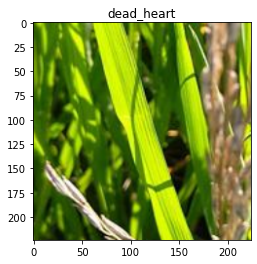

In [20]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
print(label)
print("Single image shape:",img.shape)

image_array = img.numpy()
# Transpose the array to match the channel-last format: 
"""
PyTorch, the default format for images is channel-first (C, H, W), 
where C represents the number of channels, H is the height, and W is the width. 
However, libraries like Matplotlib expect images to be in channel-last format (H, W, C).
"""
image_array = np.transpose(image_array, (1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

image_array = std * image_array + mean
"""this line clips the values in the image_array to be within the range of 0 to 1. 
Any values less than 0 will be set to 0, and any values greater than 1 will be set to 1. 
This ensures that the pixel values are bounded within a valid range, which is often 
required for proper visualization or further computations.
"""
image_array = np.clip(image_array, 0, 1)

plt.imshow(image_array)
# plt.title(idx_to_class[label.item()])
plt.title(idx_to_class[torch.argmax(label).item()])
plt.show()

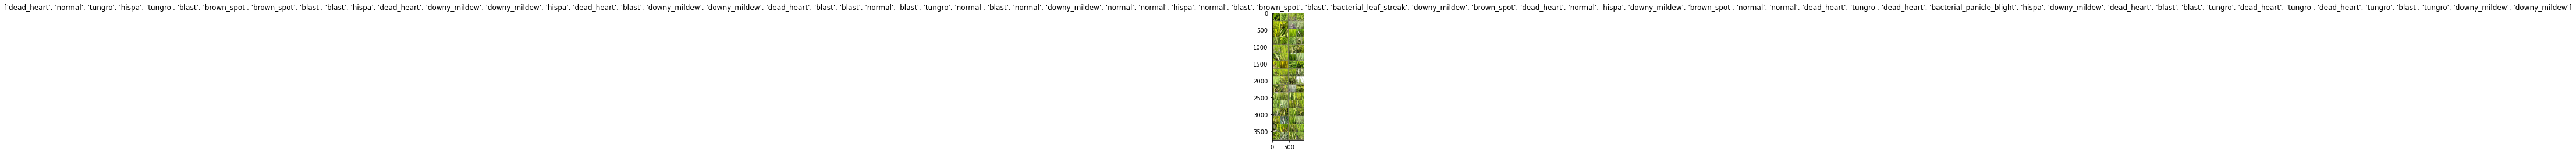

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
 
 
# Get a batch of training data
inputs, classes  = next(iter(train_loader))
# make_grid() function from the torchvision.utils module to create a grid-like image representation from a batch of input images.
out = torchvision.utils.make_grid(inputs, nrow=4, padding=10)

imshow(out, title=[class_name[torch.argmax(x).item()] for x in classes])


## BUILD THE NEURAL NETWORK

### Getting Device for training

In [22]:
device  = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device}")

Using cpu


### Define the classes

<li> When working with images, the input to the neural network is typically a flattened representation of the image. This means that each image is converted into a 1-dimensional vector before being fed into the network
    
<li> Applies a 2D convolution over an input signal composed of several input planes.

In the simplest case, the output value of the layer with input size(N, C(in), H(in), W(in)) and output (N, C(out), H(out), W(out)). N is a batch size,C denotes a number of channels, H is a height of input planes in pixels, and W is width in pixels.
    
    
<b>Note:<b>
    <br>    <li>After each convolutional layer, non-linear activation functions such as Rectified Linear Unit (ReLU) are typically applied to introduce non-linearity to the feature maps. Then, pooling layers are used to reduce the spatial size of the feature maps while preserving the most important information.
https://www.baeldung.com/cs/cnn-feature-map#:~:text=In%20CNNs%2C%20a%20feature%20map,to%20produce%20multiple%20feature%20maps.
    
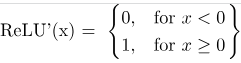
    
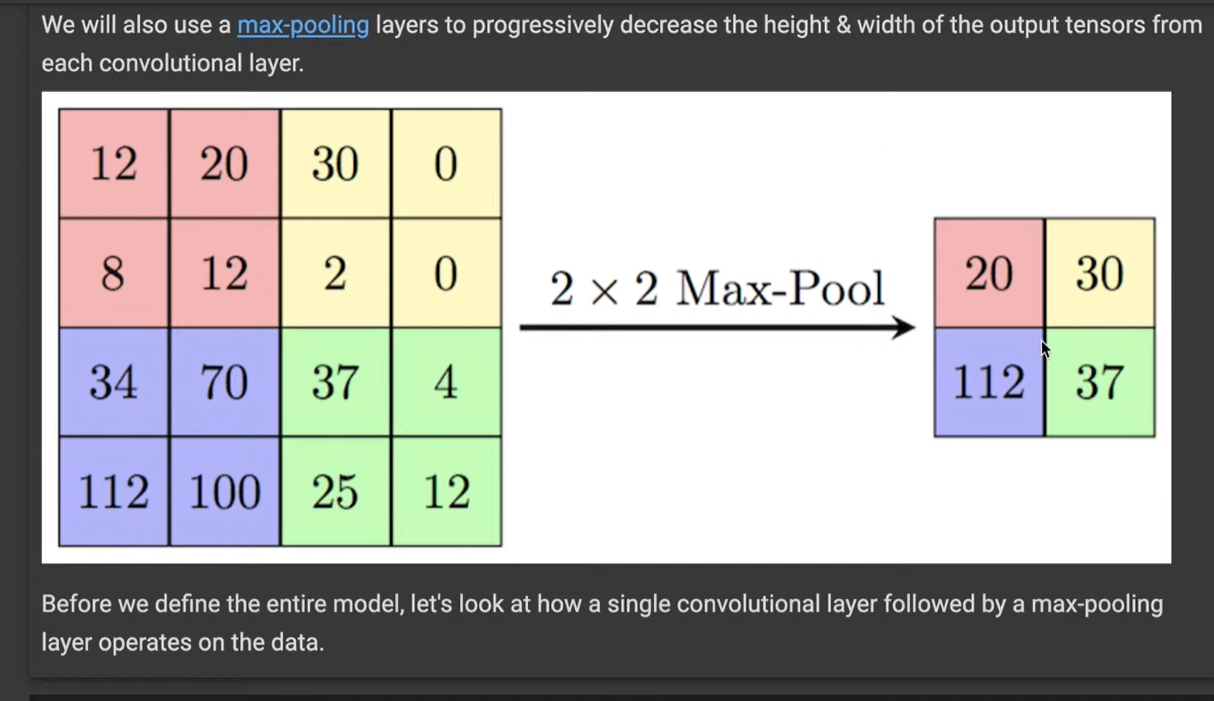

In [23]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)

In [24]:
for image, label in train_loader:
    print("image.shape:",image.shape)
    out = simple_model(image)
    print("out.shape",out.shape)
    print("label:",label)
    break

image.shape: torch.Size([64, 3, 224, 224])
out.shape torch.Size([64, 8, 112, 112])
label: tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0

<b>Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation<b>

In [25]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = torch.nn.functional.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = torch.nn.functional.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss']  for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: [{:.4f}], val_loss: [{:.4f}], val_acc: [{:.4f}]".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    _, labels = torch.max(labels, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [26]:
class MyCNN(ImageClassificationBase):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        # Define the layers of your CNN
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #Output: 64 X 112 X 112
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #Output: 128 X 56 X 56
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #Output: 256 X 28 X 28
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #Output: 512 X 14 X 14
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  #Output: 512 X 7 X 7
        )
        
        #in nn.linear we have weight and bais and when an image vector is passed then it is first multiply with 
        #weight and bias is added in it
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            
#             nn.Linear(4096, 2048),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
            
#             nn.Linear(2048, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
            
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
            
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [27]:
model = MyCNN().to(device)
print(model)

MyCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [28]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: features.0.weight | Size: torch.Size([64, 3, 3, 3]) | Values : tensor([[[[ 0.1413,  0.1885, -0.0577],
          [ 0.0584,  0.0922,  0.1054],
          [ 0.0304, -0.0131, -0.0249]],

         [[ 0.0333, -0.0918, -0.1015],
          [ 0.1581,  0.1539, -0.1272],
          [ 0.1003,  0.0425, -0.0914]],

         [[-0.0580, -0.1171,  0.1194],
          [-0.0773, -0.0150,  0.0366],
          [-0.0181,  0.0771, -0.1036]]],


        [[[ 0.1840, -0.0715, -0.1568],
          [-0.1376,  0.0230, -0.1620],
          [ 0.0182, -0.0198, -0.0642]],

         [[ 0.0622,  0.1069, -0.1640],
          [ 0.1625,  0.1715,  0.0806],
          [-0.1688, -0.1880, -0.0914]],

         [[-0.0750,  0.0553,  0.1585],
          [ 0.1184,  0.1002,  0.1414],
          [ 0.1154,  0.0729, -0.0420]]]], grad_fn=<SliceBackward0>) 

Layer: features.0.bias | Size: torch.Size([64]) | Values : tensor([ 0.0962, -0.1732], grad_fn=<SliceBackward0>) 

Layer: features.3.weight | Size: torch.Size([128, 64, 3, 3]) | Values :

In [29]:
for image, label in train_loader:
    print("image.shape:",image.shape)
    out = model(image)
    print("out.shape:",out.shape)
    print("Out[0]:",out[0])
    break

image.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 10])
Out[0]: tensor([ 0.0159,  0.0041, -0.0018, -0.0098, -0.0063,  0.0155,  0.0019,  0.0052,
        -0.0057, -0.0063], grad_fn=<SelectBackward0>)


## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:

<li>Number of Epochs - the number times to iterate over the dataset

<li>Batch Size - the number of data samples propagated through the network before the parameters are updated

<li>Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [30]:
learning_rate = 0.001
batch_size = 64
num_epochs = 5

## Loss Function

When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

In [31]:
loss_fn = nn.CrossEntropyLoss()

## Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter

In [32]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Inside the training loop, optimization happens in three steps:

Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

<b>We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.<b>

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
def fit(epochs, learning_rate, model, train_loader, val_loader, optimizer):
    history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        model.train()
        train_losses = []
#         for batch in train_loader:
        size = len(train_loader.dataset)
        for batch, (X,y) in enumerate(train_loader):
            loss= model.training_step((X,y))
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        #Validation Step:
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [34]:
# evaluate(model, val_loader)

In [ ]:
history = fit(num_epochs, learning_rate, model, train_loader, val_loader, optimizer)

Epoch 1
-------------------------------
loss: 2.303929  [   64/ 8326]
loss: 2.264431  [ 6464/ 8326]
Epoch [0], train_loss: [2.2833], val_loss: [2.2620], val_acc: [0.1636]
Epoch 2
-------------------------------
loss: 2.260850  [   64/ 8326]
loss: 2.236434  [ 6464/ 8326]
Epoch [1], train_loss: [2.2375], val_loss: [2.2185], val_acc: [0.1581]
Epoch 3
-------------------------------
loss: 2.168573  [   64/ 8326]


In [ ]:
import torch
import torch.nn as nn

# Create a 2D convolutional layer
in_channels = 3  # Number of input channels
out_channels = 64  # Number of output channels
kernel_size = 3  # Size of the convolutional kernel/filter
stride = 1  # Stride for the convolution
padding = 1  # Padding for the input tensor
conv2d_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

# Generate random input tensor
batch_size = 4
input_channels = 3
input_height = 224
input_width = 224
input_tensor = torch.randn(batch_size, input_channels, input_height, input_width)
print("input_tensor:",input_tensor)
# Apply the convolutional layer to the input tensor
output_tensor = conv2d_layer(input_tensor)
print("output_tensor:",output_tensor)
print(output_tensor.shape)  # Shape of the output tensor


In [ ]:
torch.rand(3,28,28)